In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

import seaborn as sns
from scipy import stats
from scipy.stats import truncnorm
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import warnings
import os
from copy import deepcopy

import plotting
import dataset_fctns
import modelling_fctns

from  pydynpd import regression

In [2]:
def make_cumulative(ds, driver_variable = 'tas', numdays = 200, T_base = 0):
    ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] = (np.maximum(ds.loc[:, [f'{driver_variable} at day {n}' for n in range(numdays)]] - T_base, 0)).cumsum(axis = 1)
    return ds

Get an indexing column and time indexing column.

In [3]:
def get_progressions_from_data(srs, temp_variable = 't2m', NDVI_skip = 56):
    return np.array([[srs['year'], srs['Stations_id'], n, srs[f'NDVI interpolated at day {NDVI_skip + n}'], srs[f'{temp_variable} at day {n}'], srs[f'photoperiod at day {NDVI_skip + n}'], srs[f'dev stage at day {n}']] for n in range(183)])

In [4]:
def convert_data_to_panel(ds, temp_variable = 't2m', NDVI_skip = 56):
    for point_index in range(len(ds)):
        arr_point = get_progressions_from_data(ds.iloc[point_index], temp_variable=temp_variable, NDVI_skip = NDVI_skip)
        ds_point = pd.DataFrame(arr_point, columns=['year', 'Stations_id', 'time from SOS', 'NDVI', 'acc temp', 'photoperiod', 'dev stage'])
        if point_index == 0:
            ds_panel = ds_point
        else:
            ds_panel = pd.concat([ds_panel, ds_point])
    return ds_panel

In [5]:
def logit_reg(train, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    Xtrain = train[predictors] #'NDVI', 
    ytrain = train[['dev stage']]
    
    # building the model and fitting the data
    log_reg = sm.Logit(ytrain, Xtrain).fit()
    return log_reg

In [6]:
def train_test_on_statyear(ds, train_proportion = 0.8):
    statyear = ds[['Stations_id', 'year']].drop_duplicates().values
    train_size = int(statyear.shape[0]*train_proportion)
    test_size = statyear.shape[0] - train_size
    row_choices = np.random.choice(np.arange(statyear.shape[0]), size = train_size, replace = False)
    train_statyear = pd.DataFrame(statyear[row_choices, :], columns = ['Stations_id', 'year'])
    test_statyear = pd.DataFrame(np.delete(statyear, row_choices, axis = 0), columns = ['Stations_id', 'year'])
    train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
    test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')
    return train, test


In [7]:
def anthesis_from_ds(ds, obs_column):
    return ds.loc[ds[obs_column] == 1]['time from SOS'].min()

In [8]:
def compare_logreg_test(test, log_reg, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    Xtest = test[predictors] #
    ytest = test[['dev stage']]
    with warnings.catch_warnings(action="ignore"):
        Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
        Xtest.loc[:, 'observed'] = ytest
    test = test.merge(Xtest[['fitted', 'observed']], left_index=True, right_index=True)
    test_observed = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'observed', include_groups = False)
    test_fitted = test.groupby(['Stations_id', 'year']).apply(anthesis_from_ds, 'fitted', include_groups = False)
    test_for_regression = pd.concat([test_fitted, test_observed], axis=1).rename(columns = {0: 'fitted', 1: 'observed'})
    return test_for_regression#, test

In [9]:
def plot_fitted_observed_histogram(test_for_regression, title = 'fitted vs. observed'):
    fig, ax = plt.subplots()
    sns.histplot(x='fitted', data = test_for_regression, ax=ax, label = 'fitted',
                stat = 'density')
    sns.histplot(x='observed', data = test_for_regression, ax=ax, label= 'observed',
                stat = 'density')
    ax.set_xlabel('Days to anthesis')
    ax.set_title(title)
    #ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color='k')
    fig.legend(bbox_to_anchor = (1.2, 0.9))
    rsquared = r2_score(comparison_frame['observed'], comparison_frame['fitted'])
    print(f'R^2 value for model: {rsquared}')
    bias = comparison_frame['observed'].mean() - comparison_frame['fitted'].mean()
    variance_modelled = comparison_frame[f'fitted'].var()
    print(f'Bias: {bias**2}\nVariance of modelled values: {variance_modelled}')

In [10]:
def plot_fitted_observed(test_for_regression, title = 'fitted vs observed'):
    fig, ax = plt.subplots()
    minval = test_for_regression['fitted'].min()
    maxval = test_for_regression['observed'].max()
    sns.regplot(data = test_for_regression, x = 'fitted', y ='observed', ax = ax, 
                scatter_kws={'alpha':0.5, 's':4},  x_bins=np.arange(minval - 5, maxval + 5, 3))
    ax.plot([minval, maxval], [minval, maxval], linestyle = '--', color = 'black')
    r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
    print('R2 score', r2_score_model)
    ax.set_title(title)

In [11]:
def KFold_crossval(ds, k_folds, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const']):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state = 1)
    loss_values = []
    R2s = []
    Biases = []
    Variances = []

    statyear = ds[['Stations_id', 'year']].drop_duplicates()

    for fold, (train_idx, test_idx) in enumerate(kf.split(statyear)):
        train_statyear = statyear.iloc[train_idx]
        test_statyear = statyear.iloc[test_idx]
        train = ds.merge(train_statyear, on=['Stations_id', 'year'], how = 'inner') #.loc[ds[['Stations_id', 'year']].isin(train_statyear)]
        test = ds.merge(test_statyear, on=['Stations_id', 'year'], how = 'inner')

        log_reg = logit_reg(train, predictors=predictors)
        test_for_regression = compare_logreg_test(test, log_reg, predictors=predictors)

        r2_score_model = r2_score(test_for_regression['observed'], test_for_regression['fitted'])
        bias_model = (test_for_regression['observed'] - test_for_regression['fitted']).mean()**2
        variance = test_for_regression['fitted'].var()

        R2s.append(r2_score_model)
        Biases.append(bias_model)
        Variances.append(variance)

        print(f'Fold: {fold + 1}\nR2: {r2_score_model}\nBias: {bias_model}\nVariance: {variance}')
    print(f'Average score: {np.mean(R2s)}')
    return R2s, Biases, Variances

In [68]:
ds_inputs_SSA['observed time to beginning of flowering'].min()

49

In [12]:
ds_inputs_DE = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_no_mask.csv')
ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE = make_cumulative(ds_inputs_DE, driver_variable = 't2m', numdays = 200, T_base = 0)


In [17]:
ds_inputs_SSA = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\SSA_ML.csv')
ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_SSA.loc[:, [f'temperature at day {n}' for n in range(300)]], 7, 28, 42)
ds_inputs_SSA = make_cumulative(ds_inputs_SSA, driver_variable = 'temperature', numdays = 300, T_base = 0)


In [ ]:

ds_panel_DE = convert_data_to_panel(ds_inputs_DE)
ds_panel_SSA = convert_data_to_panel(ds_inputs_SSA, temp_variable = 'temperature', NDVI_skip=0)


In [18]:

ds_panel_DE.loc[:, 'const'] = 1
ds_panel_SSA.loc[:, 'const'] = 1

In [92]:
ds_inputs_DE_mask = pd.read_csv('C:\\Users\\wlwc1989\\Documents\\Phenology_Test_Notebooks\\phenology_dwd\\results_for_comparing\\saved_ML_datasets\\DE_ML_with_mask.csv')
ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]] = modelling_fctns.Wang_Engel_Temp_response(ds_inputs_DE_mask.loc[:, [f't2m at day {n}' for n in range(200)]], 7, 28, 42)
ds_inputs_DE_mask = make_cumulative(ds_inputs_DE_mask, driver_variable = 't2m', numdays = 200, T_base = 0)

ds_panel_DE_mask = convert_data_to_panel(ds_inputs_DE_mask)

ds_panel_DE_mask.loc[:, 'const'] = 1

In [95]:
ds_panel_DE

,year,Stations_id,time from SOS,NDVI,acc temp,photoperiod,dev stage,const
0,2008.0,7504.0,0.0,0.492109,6.079668,10.933333,0.0,1
1,2008.0,7504.0,1.0,0.496533,11.683546,11.000000,0.0,1
2,2008.0,7504.0,2.0,0.500956,16.671668,11.066667,0.0,1
3,2008.0,7504.0,3.0,0.505379,22.584346,11.150000,0.0,1
4,2008.0,7504.0,4.0,0.509803,29.200264,11.216667,0.0,1
...,...,...,...,...,...,...,...,...
178,2023.0,19700.0,178.0,0.504026,2824.494665,13.766667,1.0,1
179,2023.0,19700.0,179.0,0.486355,2838.259648,13.716667,1.0,1
180,2023.0,19700.0,180.0,0.468684,2844.168914,13.650000,1.0,1
181,2023.0,19700.0,181.0,0.451013,2848.596980,13.600000,1.0,1


In [15]:
R2s, Biases, Variances = KFold_crossval(ds_panel_DE, 5, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'])#.loc[(ds_panel_DE['year'] > 2000)*(ds_panel_DE['year'] < 2005)]

Optimization terminated successfully.
         Current function value: 0.088334
         Iterations 11
Fold: 1
R2: 0.28912456242208817
Bias: 0.0016772188212922138
Variance: 74.83048587942473
Optimization terminated successfully.
         Current function value: 0.088506
         Iterations 10
Fold: 2
R2: 0.24972172997035635
Bias: 0.0013168357994442952
Variance: 76.7698649570111
Optimization terminated successfully.
         Current function value: 0.088198
         Iterations 11
Fold: 3
R2: 0.23681643362044902
Bias: 0.005418913685713218
Variance: 79.51041915381997
Optimization terminated successfully.
         Current function value: 0.088796
         Iterations 10
Fold: 4
R2: 0.26185934180018633
Bias: 0.008804256658284604
Variance: 80.53506374639954
Optimization terminated successfully.
         Current function value: 0.088769
         Iterations 10
Fold: 5
R2: 0.2947217942487572
Bias: 0.01325842358086121
Variance: 74.94740577769093
Average score: 0.2664487724123674


In [114]:
np.mean(Variances)

41.670036347227025

In [19]:
R2s_nosat, Biases_nosat, Variances_nosat = KFold_crossval(ds_panel_SSA, 5, predictors = ['NDVI', 'photoperiod', 'acc temp', 'const'])

Optimization terminated successfully.
         Current function value: 0.090439
         Iterations 11
Fold: 1
R2: 0.34300288774023
Bias: 0.057183364839319475
Variance: 105.36473429951693
Optimization terminated successfully.
         Current function value: 0.089250
         Iterations 11
Fold: 2
R2: 0.23220049553840416
Bias: 0.0018903591682419658
Variance: 115.79565217391307
Optimization terminated successfully.
         Current function value: 0.100845
         Iterations 10
Fold: 3
R2: 0.5974021202682789
Bias: 0.0
Variance: 108.69806763285024
Optimization terminated successfully.
         Current function value: 0.097278
         Iterations 11
Fold: 4
R2: 0.21885013274741383
Bias: 0.2612345679012345
Variance: 98.34040404040405
Optimization terminated successfully.
         Current function value: 0.097814
         Iterations 10
Fold: 5
R2: 0.44051042415528396
Bias: 0.9130864197530865
Variance: 104.40707070707073
Average score: 0.36639321208992215


In [117]:
np.mean(Variances_nosat)

106.521185770751

In [14]:
train, test = train_test_on_statyear(ds_panel_DE, train_proportion = 0.98)
log_reg = logit_reg(train, predictors = ['NDVI', 'acc temp', 'photoperiod', 'const'])
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.088490
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              dev stage   No. Observations:              1729533
Model:                          Logit   Df Residuals:                  1729529
Method:                           MLE   Df Model:                            3
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                  0.8720
Time:                        17:56:22   Log-Likelihood:            -1.5305e+05
converged:                       True   LL-Null:                   -1.1957e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
NDVI            0.7466      0.052     14.298      0.000       0.644       0.849
acc temp        0.2838   

In [122]:
test_for_regression = compare_logreg_test(ds_panel_DE.reset_index(), log_reg, predictors = ['acc temp', 'photoperiod',  'const'])
#test_for_regression = compare_logreg_test(test, log_reg, predictors = ['acc temp', 'photoperiod',  'const'])

R2 score 0.33170884434797243


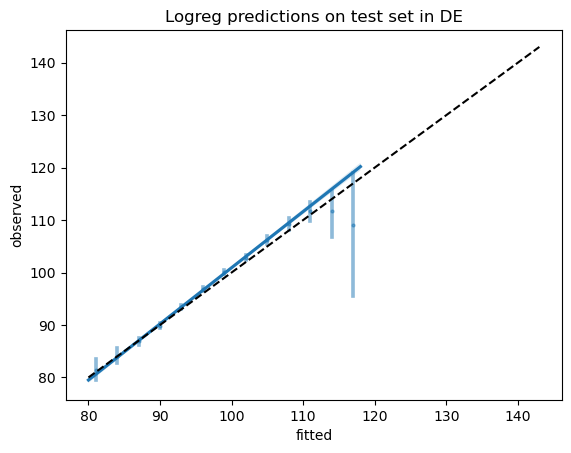

In [123]:
plot_fitted_observed(test_for_regression, 'Logreg predictions on test set in DE')

In [25]:
import torch.nn as nn
import torch

In [40]:
loss_func = nn.NLLLoss()
output = torch.swapaxes(torch.stack([torch.Tensor(test['fitted']), torch.Tensor(1 - test['fitted'])]), 0, 1)
loss_func(output, torch.Tensor(test['observed']).long()).item()

-0.04668327048420906

In [39]:
output.shape

torch.Size([2, 262422])

In [15]:
test_for_regression

fitted  observed
Stations_id year                    
7521.0      2018.0    98.0      95.0
            2019.0   107.0     105.0
            2020.0   113.0     107.0
            2022.0   110.0      99.0
7608.0      2019.0   102.0     102.0
...                    ...       ...
19585.0     2020.0   108.0     103.0
            2022.0   105.0     102.0
19700.0     2018.0    94.0     101.0
            2019.0   100.0     112.0
            2020.0   107.0     123.0

[1434 rows x 2 columns]

NameError: name 'comparison_frame' is not defined

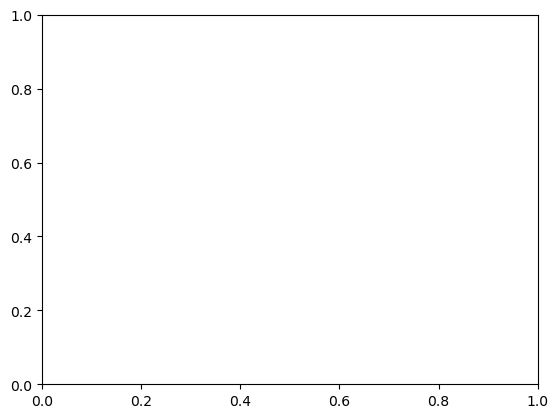

In [20]:
test_for_SSA, Xtest = compare_logreg_test(ds_panel_SSA.reset_index(), log_reg)

R2 score 0.05587869830011427


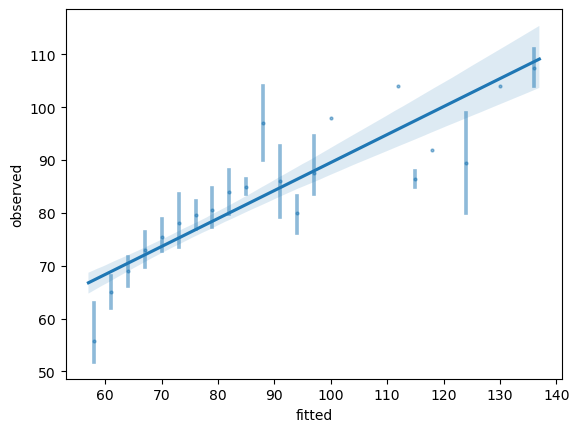

In [33]:
plot_fitted_observed(test_for_SSA)

In [20]:
(test_for_SSA['fitted'] - test_for_SSA['observed']).min()

-62.0

In [199]:
plot_fitted_observed(test_for_SSA)

ValueError: attempt to get argmin of an empty sequence

In [174]:
Xtest = test[['NDVI', 'acc temp', 'photoperiod', 'const']]
ytest = test[['dev stage']]
    
yhat = log_reg.predict(Xtest)
prediction = list(map(round, yhat))

# comparing original and predicted values of y
print('Actual values', list(ytest.values.squeeze()))
print('Predictions :', prediction)

Actual values [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [175]:
with warnings.catch_warnings(action="ignore"):
    Xtest.loc[:, 'fitted'] = log_reg.predict(Xtest).round()
    Xtest.loc[:, 'observed'] = ytest

In [46]:
Xtrain = ds_panel_DE[['NDVI', 'acc temp', 'photoperiod']]
ytrain = ds_panel_DE[['dev stage']]
 
# building the model and fitting the data
log_reg = sm.Logit(ytrain, Xtrain).fit()

Optimization terminated successfully.
         Current function value: 0.088185
         Iterations 10
